In [2]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import os,sys
import pandas as pd
import helper
import simulation

import glob
import cv2
import random
import matplotlib.pyplot as plt
import numpy as np

FIXED_SIZE = 32

def load_image(imagePath):
    im = cv2.imread(imagePath)[...,::-1]
    im = cv2.resize(im, (FIXED_SIZE, FIXED_SIZE))
    return im

def load_dataset(isTraining):

    image_folder = "./roi_images/"
    mask_folder = "./roi_masks/"

    masks = sorted(glob.glob(os.path.join(mask_folder, "*.png")))
    images = []
    for mask_path in masks:
        images.append(os.path.join(image_folder, ((mask_path.split('/')[-1]).split("_mask.png")[0] + ".png")))

    dataSize = len(images)

    input_images = np.zeros((dataSize, FIXED_SIZE, FIXED_SIZE, 3))
    target_masks = np.zeros((dataSize, 1, FIXED_SIZE, FIXED_SIZE))

    for i, image in enumerate(images):
        im = load_image(image)
        input_images[i] = im

    for i, mask in enumerate(masks):
        mask = load_image(mask)
        mask = cv2.cvtColor(mask, cv2.COLOR_RGB2GRAY)
        mask = mask.astype('bool')
        target_masks[i][0] = mask
    
    trainSize = int(dataSize * 0.8)

    if isTraining:
        train_images = input_images[:trainSize,...]
        train_masks = target_masks[:trainSize,...]
        return train_images.astype(np.uint8), train_masks
    else:
        val_images = input_images[trainSize:,...]
        val_masks = target_masks[trainSize:,...]
        return val_images.astype(np.uint8), val_masks

(3, 32, 32, 3)
0 180
(3, 1, 32, 32)
0.0 1.0


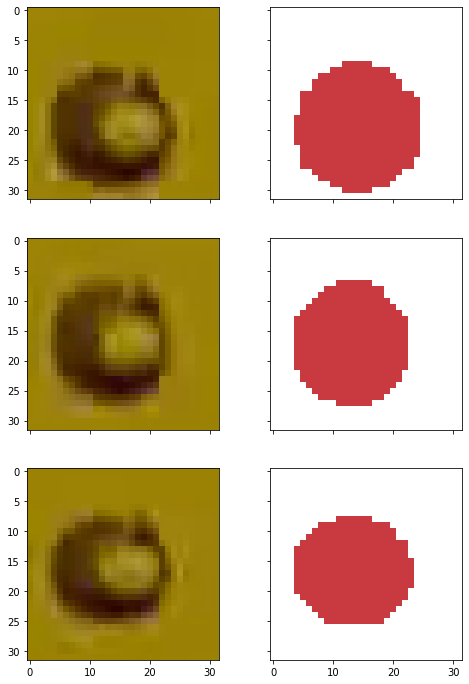

In [3]:
input_images, target_masks = load_dataset(True)
selected_input_images = input_images[:3,...]
selected_target_masks = target_masks[:3,...]

for x in [selected_input_images, selected_target_masks]:
    print(x.shape)
    print(x.min(), x.max())

# Change channel-order and make 3 channels for matplot
input_images_rgb = [x.astype(np.uint8) for x in selected_input_images]

# Map each channel (i.e. class) to each color
target_masks_rgb = [helper.masks_to_colorimg(x) for x in selected_target_masks]

# Left: Input image, Right: Target mask (Ground-truth)
helper.plot_side_by_side([input_images_rgb, target_masks_rgb])

In [4]:
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, datasets, models

class SimDataset(Dataset):
    def __init__(self, isTraining, transform=None):
        self.input_images, self.target_masks = load_dataset(isTraining)
        self.transform = transform
    
    def __len__(self):
        return len(self.input_images)
    
    def __getitem__(self, idx):        
        image = self.input_images[idx]
        mask = self.target_masks[idx]
        if self.transform:
            image = self.transform(image)
        
        return [image, mask]

# use same transform for train/val for this example
trans = transforms.Compose([
    transforms.ToTensor(),
])

train_set = SimDataset(True, transform = trans)
val_set = SimDataset(False, transform = trans)

image_datasets = {
    'train': train_set, 'val': val_set
}

batch_size = 25

dataloaders = {
    'train': DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=0),
    'val': DataLoader(val_set, batch_size=batch_size, shuffle=True, num_workers=0)
}

dataset_sizes = {
    x: len(image_datasets[x]) for x in image_datasets.keys()
}

dataset_sizes

{'train': 94, 'val': 24}

torch.Size([25, 3, 32, 32]) torch.Size([25, 1, 32, 32])
0.0 0.8509804 0.35313755 0.24806723
0.0 1.0 0.301640625 0.45897010616118494


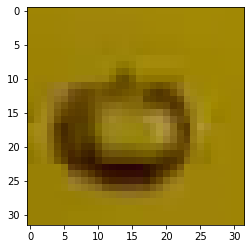

In [5]:
import torchvision.utils

def reverse_transform(inp):

    inp = inp.numpy().transpose((1, 2, 0))
    inp = np.clip(inp, 0, 1)
    inp = (inp * 255).astype(np.uint8)
    
    return inp

# Get a batch of training data
inputs, masks = next(iter(dataloaders['train']))

print(inputs.shape, masks.shape)
for x in [inputs.numpy(), masks.numpy()]:
    print(x.min(), x.max(), x.mean(), x.std())

plt.imshow(reverse_transform(inputs[3]))

In [6]:
from torchsummary import summary
import torch
import torch.nn as nn
import pytorch_unet

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = pytorch_unet.UNet(1)
model = model.to(device)

summary(model, input_size=(3, FIXED_SIZE, FIXED_SIZE))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,792
              ReLU-2           [-1, 64, 32, 32]               0
            Conv2d-3           [-1, 64, 32, 32]          36,928
              ReLU-4           [-1, 64, 32, 32]               0
         MaxPool2d-5           [-1, 64, 16, 16]               0
            Conv2d-6          [-1, 128, 16, 16]          73,856
              ReLU-7          [-1, 128, 16, 16]               0
            Conv2d-8          [-1, 128, 16, 16]         147,584
              ReLU-9          [-1, 128, 16, 16]               0
        MaxPool2d-10            [-1, 128, 8, 8]               0
           Conv2d-11            [-1, 256, 8, 8]         295,168
             ReLU-12            [-1, 256, 8, 8]               0
           Conv2d-13            [-1, 256, 8, 8]         590,080
             ReLU-14            [-1, 25

In [7]:
from collections import defaultdict
import torch.nn.functional as F
from loss import dice_loss

def calc_loss(pred, target, metrics, bce_weight=0.5):
    bce = F.binary_cross_entropy_with_logits(pred, target)
        
    pred = F.sigmoid(pred)
    dice = dice_loss(pred, target)
    
    loss = bce * bce_weight + dice * (1 - bce_weight)
    
    metrics['bce'] += bce.data.cpu().numpy() * target.size(0)
    metrics['dice'] += dice.data.cpu().numpy() * target.size(0)
    metrics['loss'] += loss.data.cpu().numpy() * target.size(0)
    
    return loss

def print_metrics(metrics, epoch_samples, phase):    
    outputs = []
    for k in metrics.keys():
        outputs.append("{}: {:4f}".format(k, metrics[k] / epoch_samples))
        
    print("{}: {}".format(phase, ", ".join(outputs)))    

def train_model(model, optimizer, scheduler, num_epochs=25):
    best_model_wts = copy.deepcopy(model.state_dict())
    best_loss = 1e10

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)
        
        since = time.time()

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                scheduler.step()
                for param_group in optimizer.param_groups:
                    print("LR", param_group['lr'])
                    
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            metrics = defaultdict(float)
            epoch_samples = 0
            
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)             

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    loss = calc_loss(outputs, labels, metrics)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                epoch_samples += inputs.size(0)

            print_metrics(metrics, epoch_samples, phase)
            epoch_loss = metrics['loss'] / epoch_samples

            # deep copy the model
            if phase == 'val' and epoch_loss < best_loss:
                print("saving best model")
                best_loss = epoch_loss
                best_model_wts = copy.deepcopy(model.state_dict())

        time_elapsed = time.time() - since
        print('{:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val loss: {:4f}'.format(best_loss))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [8]:
import torch
import torch.optim as optim
from torch.optim import lr_scheduler
import time
import copy

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

num_class = 1

model = pytorch_unet.UNet(num_class).to(device)

# Observe that all parameters are being optimized
optimizer_ft = optim.Adam(model.parameters(), lr=1e-4)

exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=25, gamma=0.1)

model = train_model(model, optimizer_ft, exp_lr_scheduler, num_epochs=50)

Epoch 0/49
----------
LR 0.0001
train: bce: 0.681629, dice: 0.631466, loss: 0.656547


/home/turtle/miniforge3/envs/py37/lib/python3.7/site-packages/torch/optim/lr_scheduler.py:136: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)
/home/turtle/miniforge3/envs/py37/lib/python3.7/site-packages/torch/nn/functional.py:1639: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


val: bce: 0.680045, dice: 0.630393, loss: 0.655219
saving best model
0m 0s
Epoch 1/49
----------
LR 0.0001
train: bce: 0.678687, dice: 0.632131, loss: 0.655409
val: bce: 0.677170, dice: 0.631166, loss: 0.654168
saving best model
0m 0s
Epoch 2/49
----------
LR 0.0001
train: bce: 0.675630, dice: 0.632571, loss: 0.654101
val: bce: 0.673714, dice: 0.631026, loss: 0.652370
saving best model
0m 0s
Epoch 3/49
----------
LR 0.0001
train: bce: 0.671289, dice: 0.631319, loss: 0.651304
val: bce: 0.666694, dice: 0.627662, loss: 0.647178
saving best model
0m 0s
Epoch 4/49
----------
LR 0.0001
train: bce: 0.659238, dice: 0.626164, loss: 0.642701
val: bce: 0.637345, dice: 0.625289, loss: 0.631317
saving best model
0m 0s
Epoch 5/49
----------
LR 0.0001
train: bce: 0.606256, dice: 0.610798, loss: 0.608527
val: bce: 0.523412, dice: 0.554943, loss: 0.539178
saving best model
0m 0s
Epoch 6/49
----------
LR 0.0001
train: bce: 0.448501, dice: 0.492382, loss: 0.470442
val: bce: 0.461333, dice: 0.344434, loss

(3, 1, 32, 32)


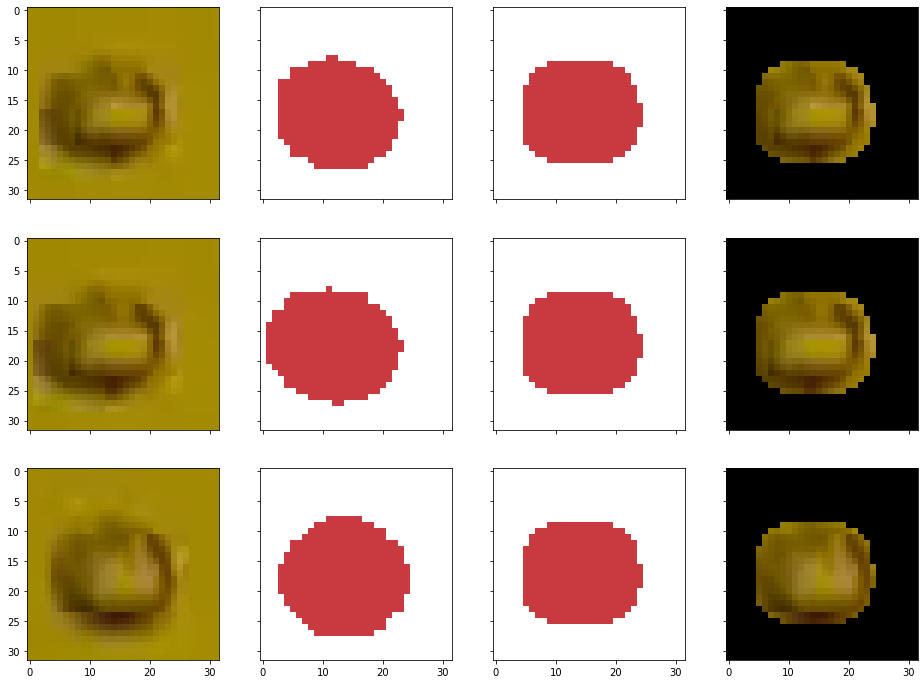

In [22]:
# prediction

import math

model.eval()   # Set model to evaluate mode

test_dataset = SimDataset(False, transform = trans)
test_loader = DataLoader(test_dataset, batch_size=3, shuffle=False, num_workers=0)
        
inputs, labels = next(iter(test_loader))
inputs = inputs.to(device)
labels = labels.to(device)

pred = model(inputs)

pred = pred.data.cpu().numpy()
print(pred.shape)

# Change channel-order and make 3 channels for matplot
input_images_rgb = [reverse_transform(x) for x in inputs.cpu()]

# Map each channel (i.e. class) to each color
target_masks_rgb = [helper.masks_to_colorimg(x) for x in labels.cpu().numpy()]
pred_rgb = [helper.masks_to_colorimg(x) for x in pred]

masked_inputs = []

for i in range(3):
    mask = cv2.cvtColor(pred_rgb[i], cv2.COLOR_RGB2GRAY)
    mask = 255 - mask
    masked = cv2.bitwise_and(input_images_rgb[i], input_images_rgb[i], mask=mask)
    masked_inputs.append(masked)

helper.plot_side_by_side([input_images_rgb, target_masks_rgb, pred_rgb, masked_inputs])